In [132]:
import pandas as pd
from sqlalchemy import create_engine
from pandas.io import sql
import pickle
import os.path
from os import path

# Database creds, don't share on public repo
hostname='95.217.156.58'
dbname='crimeStats'
uname='sandwich'
pwd='321#@!IdiotSandwich'
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd))

# pulls clean data from repo and saves locally
if path.exists("crime.dat"):
    print("Found crime data. Loading as pandas df")
    fh = open("crime.dat", 'rb')
    df = pickle.load(fh)
    fh.close()
else:
    print("Crime data not downloaded, saving file in root dir as crime.dat")
    print("Downloading 1.2GB, this may take a while...")
    df = pd.read_sql('SELECT * FROM crimeTable', con=engine)
    fh = open('crime.dat', 'wb+')
    pickle.dump(df, fh)
    fh.close()

Found crime data. Loading as pandas df


In [133]:
# Extra imports

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ipyleaflet import Map, Heatmap


In [134]:
# since our data ends NYE on 2019, well do the last five years from that date

df['arrest_date'] = pd.to_datetime(df['arrest_date'], format='%Y-%m-%d')
  
# Filter data between two dates (modified to get full winter season)
recent_df = df.loc[(df['arrest_date'] >= '2014-12-01')]
# Display
recent_df

,arrest_key,arrest_date,pd_desc,ofns_desc,law_code,law_cat_cd,age_group,perp_sex,perp_race,latitude,longitude,arrest_boro,arrest_precinct,jurisdiction_code,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih
0,192799737,2019-01-26,SEXUAL ABUSE,SEX CRIMES,PL 1306503,F,45-64,M,BLACK,40.800694,-73.941109,M,25,0.0,7.0,4.0,36.0,16.0
1,193260691,2019-02-06,CRIMINAL SALE OF A CONTROLLED SUBSTANCE,CONTROLLED SUBSTANCES OFFENSES,PL 2203400,F,25-44,M,UNKNOWN,40.757839,-73.991212,M,14,0.0,12.0,4.0,10.0,8.0
2,149117452,2016-01-06,RAPE 3,RAPE,PL 1302503,F,25-44,M,BLACK,40.648650,-73.950336,K,67,0.0,61.0,2.0,11.0,40.0
3,190049060,2018-11-15,RAPE 1,RAPE,PL 1303501,F,25-44,M,BLACK,40.674583,-73.930222,K,77,0.0,16.0,2.0,49.0,49.0
5,189182271,2018-10-24,RAPE 3,RAPE,PL 1302503,F,45-64,M,WHITE HISPANIC,40.716196,-73.997491,M,5,0.0,70.0,4.0,32.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309990,140224513,2014-12-17,"MARIJUANA, POSSESSION 4 & 5",DANGEROUS DRUGS,PL 2211001,M,18-24,M,WHITE HISPANIC,40.832388,-73.940886,M,33,0.0,47.0,4.0,23.0,21.0
1310000,140169499,2014-12-13,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,25-44,M,BLACK,40.674600,-73.930575,K,77,0.0,16.0,2.0,49.0,49.0
1310005,140085794,2014-12-07,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",PETIT LARCENY,PL 1552500,M,25-44,M,BLACK,40.751600,-73.992043,M,14,0.0,11.0,4.0,10.0,8.0
1310022,140049718,2014-12-04,"BURGLARY,UNCLASSIFIED,UNKNOWN TIME",BURGLARY,PL 1402000,F,25-44,M,BLACK,40.683379,-73.909329,K,83,0.0,42.0,2.0,37.0,53.0


In [135]:
# lets first look into patterns
# to do so I want to see if there are a 
# certain type of crime that occurs in "tourist areas"
# My hypothesis is that itll be property crimes or pickpocketing

# start with bounding boxes
cenPark = [(40.801726, -73.959202),
            (40.796788, -73.947173),
            (40.762975, -73.971899),
            (40.768549, -73.985223)]
rockCenter = [(40.760521, -73.979950),
              (40.759147, -73.976719),
              (40.757278, -73.978104),
              (40.758643, -73.981337)]
tSquare = [(40.761000, -73.987014),
            (40.758643, -73.981322),
            (40.754832, -73.984094),
            (40.757197, -73.989781)]
empire = [(40.750459, -73.987300),
            (40.749110, -73.984060),
            (40.747151, -73.985488),
            (40.748509, -73.988730)]
WTCmemorial = [(40.712882, -74.014008),
            (40.712028, -74.011934),
            (40.710134, -74.012664),
            (40.710955, -74.014424)]

def getLatLonLists(boundingBox):
    lat = []
    lon = []
    for i in boundingBox:
        lat.append(i[0])
        lon.append(i[1])
        
    return lat,lon

def getMaxMin(boundingBox):
    lat = []
    lon = []
    for i in boundingBox:
        lat.append(i[0])
        lon.append(i[1])
    
    lat = (min(lat),max(lat))
    lon = (min(lon),max(lon))
        
    return [lat,lon]

In [136]:
# max and min will allow us to get
# the location from the dataset

centralMM = getMaxMin(cenPark)
rockaMM = getMaxMin(rockCenter)
timesMM = getMaxMin(tSquare)
empireMM = getMaxMin(empire)
wtcMM = getMaxMin(WTCmemorial)


In [137]:
# try filtering central park first

print(centralMM)
central = recent_df.loc[(recent_df['latitude'] >= centralMM[0][0]) & 
                        (recent_df['latitude'] <= centralMM[0][1]) & 
                        (recent_df['longitude'] >= centralMM[1][0]) & 
                        (recent_df['longitude'] <= centralMM[1][1])]
central

[(40.762975, 40.801726), (-73.985223, -73.947173)]


,arrest_key,arrest_date,pd_desc,ofns_desc,law_code,law_cat_cd,age_group,perp_sex,perp_race,latitude,longitude,arrest_boro,arrest_precinct,jurisdiction_code,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih
17,201100692,2019-08-14,STRANGULATION 1ST,FELONY ASSAULT,PL 1211200,F,25-44,M,BLACK,40.789348,-73.947352,M,23,0.0,7.0,4.0,35.0,14.0
54,192399624,2019-01-16,RAPE 3,RAPE,PL 1302501,F,18-24,M,BLACK,40.764818,-73.985190,M,18,0.0,12.0,4.0,10.0,10.0
68,188126065,2018-09-28,FORGERY,FORGERY,PL 1701000,F,25-44,M,WHITE HISPANIC,40.790322,-73.947687,M,23,1.0,7.0,4.0,35.0,14.0
73,194097220,2019-02-28,"SEXUAL ABUSE 3,2",SEX CRIMES,PL 13052A1,M,45-64,M,BLACK,40.767177,-73.963807,M,19,1.0,23.0,4.0,51.0,11.0
96,197611327,2019-05-25,SODOMY 3,SEX CRIMES,PL 1304003,F,25-44,M,BLACK,40.764818,-73.985190,M,18,0.0,12.0,4.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309716,139937232,2014-12-03,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",PETIT LARCENY,PL 1552500,M,<18,M,BLACK,40.768899,-73.982095,M,18,1.0,20.0,4.0,10.0,12.0
1309733,140200092,2014-12-16,"NY STATE LAWS,UNCLASSIFIED VIOLATION",OTHER STATE LAWS,LOC000000V,V,25-44,M,BLACK,40.778805,-73.982060,M,20,0.0,20.0,4.0,19.0,12.0
1309754,140062575,2014-12-05,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,25-44,M,WHITE,40.767862,-73.953019,M,19,0.0,23.0,4.0,1.0,11.0
1309884,140189468,2014-12-15,"TRAFFIC,UNCLASSIFIED MISDEMEAN",VEHICLE AND TRAFFIC LAWS,VTL0511001,M,25-44,M,BLACK,40.766174,-73.954248,M,19,0.0,23.0,4.0,1.0,11.0


In [138]:
relCols = ["latitude","longitude","ofns_desc"]
mapdf = central[relCols]
#mapdf = mapdf[mapdf["ofns_desc"]=="F"]
#mapdf["law_cat_cd"].replace({"F": 1000}, inplace=True)

heatList = []
for index, row in mapdf.iterrows():
    heatList.append([row['latitude'], row['longitude'],1000])

grad = {0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
heatmap = Heatmap(locations=heatList,radius=3,blur=9)
m = Map(center=(40.785091, -73.968285), zoom=11, gradient=grad)
m.add_layer(heatmap)
m

Map(center=[40.785091, -73.968285], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [139]:
centralMM = getMaxMin(cenPark)
rockaMM = getMaxMin(rockCenter)
timesMM = getMaxMin(tSquare)
empireMM = getMaxMin(empire)
wtcMM = getMaxMin(WTCmemorial)

In [140]:
# thats not good, we cant define it via the min and max of the 
# bounding box, so we have to take a different approach

# Have to cut up into a bunch of small boxes... 

cpark = [[-73.9776286093,40.7640302471,-73.9710840194,40.7662079996],
[-73.9820560639,40.7662802508,-73.9694818681,40.7690754673],
[-73.982002,40.76901,-73.967476,40.773106],
[-73.9790789725,40.7713921513,-73.9657323004,40.7768845427],
[-73.9765791537,40.7741465286,-73.9637903811,40.7803211188],
[-73.974422,40.776662,-73.961934,40.783227],
[-73.972555,40.779538,-73.959938,40.78594],
[-73.9700234562,40.7819429518,-73.9580929905,40.7894165053],
[-73.9670622975,40.7840876228,-73.9565909535,40.7933479067],
[-73.964895,40.786573,-73.954681,40.794371],
[-73.9626349722,40.7890310373,-73.9528931891,40.7970236057],
[-73.9610685622,40.7916303521,-73.9510263716,40.7992002768],
[-73.9600385939,40.7939046691,-73.9492668425,40.8006134503],
[-73.9582790648,40.7949849424,-73.948515824,40.8029443088]]

def bboxitir(arealist):
    datasets = []
    for i in arealist:
        dset = recent_df.loc[(recent_df['latitude'] >= i[1]) & 
                        (recent_df['latitude'] <= i[3]) & 
                        (recent_df['longitude'] >= i[0]) & 
                        (recent_df['longitude'] <= i[2])]
        datasets.append(dset)
    frame = pd.concat(datasets)
    frame = frame.drop_duplicates()
    return frame

In [141]:
central = bboxitir(cpark)

In [142]:
relCols = ["latitude","longitude","ofns_desc"]
mapdf = central[relCols]
#mapdf = mapdf[mapdf["ofns_desc"]=="F"]
#mapdf["law_cat_cd"].replace({"F": 1000}, inplace=True)

heatList = []
for index, row in mapdf.iterrows():
    heatList.append([row['latitude'], row['longitude'],1000])

grad = {0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
heatmap = Heatmap(locations=heatList,radius=3,blur=9)
m = Map(center=(40.785091, -73.968285), zoom=11, gradient=grad)
m.add_layer(heatmap)
m

Map(center=[40.785091, -73.968285], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [143]:
# way better, side note, its cool to see that most crime seems to be commited
# AROUND, not in, the park

a = central.groupby(['ofns_desc']).size().reset_index(name='count')
a.sort_values('count',ascending=False)

,ofns_desc,count
10,DANGEROUS DRUGS,1915
4,ASSAULT 3 & RELATED OFFENSES,612
44,OTHER OFFENSES RELATED TO THEFT,562
60,VEHICLE AND TRAFFIC LAWS,453
49,PETIT LARCENY,382
...,...,...
32,MURDER & NON-NEGL. MANSLAUGHTE,1
53,RAPE,1
13,ESCAPE 3,1
24,HARRASSMENT 2,1


In [144]:
# okay this looks like a good system to get locations
# we can apply it to the other 4 locations

rcent = [[-73.9805664026,40.7595309332,-73.9785708391,40.7604817415],
[-73.9798582995,40.7590108271,-73.977862736,40.7599616429],
[-73.979364773,40.7587263924,-73.9773692095,40.7596772123],
[-73.9789356196,40.7585638577,-73.9769400561,40.7595146799],
[-73.9786781275,40.7584338297,-73.976682564,40.7593846537],
[-73.9791287386,40.7578730809,-73.9771331751,40.758823913],
[-73.980019232,40.7582306604,-73.9780236685,40.7591814874],
[-73.9808238947,40.7585963647,-73.9788283312,40.7595471864],
[-73.981456896,40.7589539403,-73.9794613325,40.7599047569],
[-73.9817036593,40.7584744635,-73.9797080958,40.759425287],
[-73.9806200468,40.75800311,-73.9786244833,40.7589539403],
[-73.979826113,40.757718671,-73.9778305495,40.7586695053],
[-73.9794184172,40.7571822969,-73.9774228537,40.7581331389]]

tsq = [[-73.9879317486,40.7550347256,-73.9857967102,40.7562334731],
[-73.9874167645,40.75595309,-73.9852817261,40.757151821],
[-73.9871592724,40.7566682677,-73.985024234,40.7578669858],
[-73.9867515766,40.7573509302,-73.9846165383,40.7585496359],
[-73.9862473213,40.7583667839,-73.984112283,40.7595654713],
[-73.9859791004,40.7588462614,-73.9838440621,40.7600449402],
[-73.9855714047,40.7595207749,-73.9834363663,40.7607194415],
[-73.9852280819,40.760114016,-73.9830930435,40.7613126719]]

emp = [[-73.9885325634,40.7495567839,-73.986397525,40.7507556302],
[-73.9875347817,40.7489878324,-73.9853997433,40.7501866889],
[-73.9868695938,40.7486952268,-73.9847345555,40.7498940886],
[-73.9860971176,40.748370108,-73.9839620793,40.7495689757],
[-73.9863867962,40.7477686341,-73.9842517578,40.7489675126],
[-73.9869983399,40.7479311951,-73.9848633015,40.7491300707],
[-73.9885218346,40.7486139473,-73.9863867962,40.7498128105],
[-73.9878030026,40.748231932,-73.9856679642,40.7494308022],
[-73.988886615,40.7488659135,-73.9867515766,40.7500647723],
[-73.9892138547,40.7473622297,-73.9870788164,40.7485611155]]

mem = [[-74.0142605333,40.7120397129,-74.0127584963,40.7129119101],
[-74.0134075909,40.7116005603,-74.0119055538,40.7124727633],
[-74.0144965677,40.7111858024,-74.0129945307,40.7120580108],
[-74.0136650829,40.7108767654,-74.0121630459,40.7117489779],
[-74.014577034,40.7104498041,-74.013074997,40.7113220222],
[-74.0139064818,40.7101163657,-74.0124044447,40.7109885882],
[-74.0145663052,40.7101122994,-74.0130642681,40.7109845219],
[-74.0140191345,40.7095348777,-74.0125170975,40.7104071078]]

In [145]:
rockafeller = bboxitir(rcent)
times = bboxitir(tsq)
empire = bboxitir(emp)
mem = bboxitir(mem)

In [146]:
b = rockafeller.groupby(['ofns_desc']).size().reset_index(name='count')

In [147]:
c = times.groupby(['ofns_desc']).size().reset_index(name='count')

In [148]:
d = empire.groupby(['ofns_desc']).size().reset_index(name='count')

In [149]:
e = mem.groupby(['ofns_desc']).size().reset_index(name='count')

In [150]:
crimes = ["ASSAULT 3 & RELATED OFFENSES",
"PETIT LARCENY",
"OTHER OFFENSES RELATED TO THEFT",
"OTHER OFFENSES RELATED TO THEF",
"GRAND LARCENY",
"BURGLARY",
"LARCENY",
"POSSESSION OF STOLEN PROPERTY",
"POSSESSION OF STOLEN PROPERTY 5",
"FELONY ASSAULT",
"ROBBERY",
"THEFT-FRAUD",
"THEFT",
"JOSTLING"]

In [151]:
aCrimes = a.loc[a['ofns_desc'].isin(crimes)]
bCrimes = b.loc[b['ofns_desc'].isin(crimes)]
cCrimes = c.loc[c['ofns_desc'].isin(crimes)]
dCrimes = d.loc[d['ofns_desc'].isin(crimes)]
eCrimes = e.loc[e['ofns_desc'].isin(crimes)]

In [152]:
eCrimes['count'].sum()

8

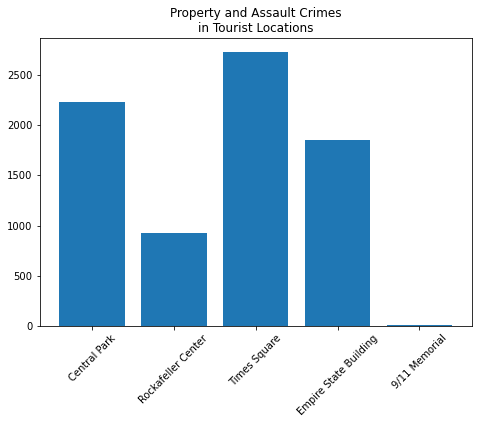

In [153]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
locs = ['Central Park', 'Rockafeller Center', 'Times Square', 'Empire State Building', '9/11 Memorial']
crimes = [aCrimes['count'].sum(),bCrimes['count'].sum(),cCrimes['count'].sum(),dCrimes['count'].sum(),eCrimes['count'].sum()]
ax.bar(locs,crimes)
plt.xticks(rotation = 45)
plt.title("Property and Assault Crimes\nin Tourist Locations")
plt.show()

In [154]:
# lets just get a heatmap of the areas now too

sets = [central, rockafeller, times, empire, mem]

dframe = pd.concat(sets)

relCols = ["latitude","longitude","ofns_desc"]
mapdf = dframe[relCols]
#mapdf = mapdf[mapdf["ofns_desc"]=="F"]
#mapdf["law_cat_cd"].replace({"F": 1000}, inplace=True)

heatList = []
for index, row in mapdf.iterrows():
    heatList.append([row['latitude'], row['longitude'],1000])

grad = {0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
heatmap = Heatmap(locations=heatList,radius=3,blur=9)
m = Map(center=(40.785091, -73.968285), zoom=11, gradient=grad)
m.add_layer(heatmap)
m

Map(center=[40.785091, -73.968285], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [155]:
# TODO: Adjust time abouve to incorporate seasons (winter) better, instead of approximation from EDA -DONE

# TODO: create a gif/video of seasons and years heatmapped for crime

# TODO: year to year/ season to season comparisons. can prob be done around the same time as heatmap. generate graphs too maybe
# Use this to inform/find trends. maybe look at types of crime per season. theft, robbery, etc. -DONE

In [157]:
# this will get us the dataframes of specific seasons

def getSeasonData(season,endYear):
    if season == "winter":
        df =  recent_df[((recent_df.arrest_date >= str(endYear-1)+'-12-01') & (recent_df.arrest_date <= str(endYear)+'-02-28'))]
    if season == "spring":
        df =  recent_df[((recent_df.arrest_date >= str(endYear)+'-03-01') & (recent_df.arrest_date <= str(endYear)+'-05-31'))]
    if season == "fall":
        df = recent_df[((recent_df.arrest_date >= str(endYear)+'-09-01') & (recent_df.arrest_date <= str(endYear)+'-11-30'))]
    if season == "summer":
        df = recent_df[((recent_df.arrest_date >= str(endYear)+'-06-01') & (recent_df.arrest_date <= str(endYear)+'-08-31'))]
    return df

In [158]:
seasons = []
x = 2015
for i in range(5):
    seasons.append(getSeasonData('winter',x+i))
    seasons.append(getSeasonData('spring',x+i))
    seasons.append(getSeasonData('summer',x+i))
    seasons.append(getSeasonData('fall',x+i))

In [159]:
len(seasons)

20

In [160]:
j = 0
y = 2014
season = []
crimeAmt = []
for i in seasons:
    if j == 0:
        y = y+1
        season.append("winter " + str(y))
    if j == 1:
        season.append("spring " + str(y))
    if j == 2:
        season.append("summer " + str(y))
    if j == 3:
        season.append("fall " + str(y))
        j= -1
    j=j+1
    
    crimeAmt.append(i.shape[0])

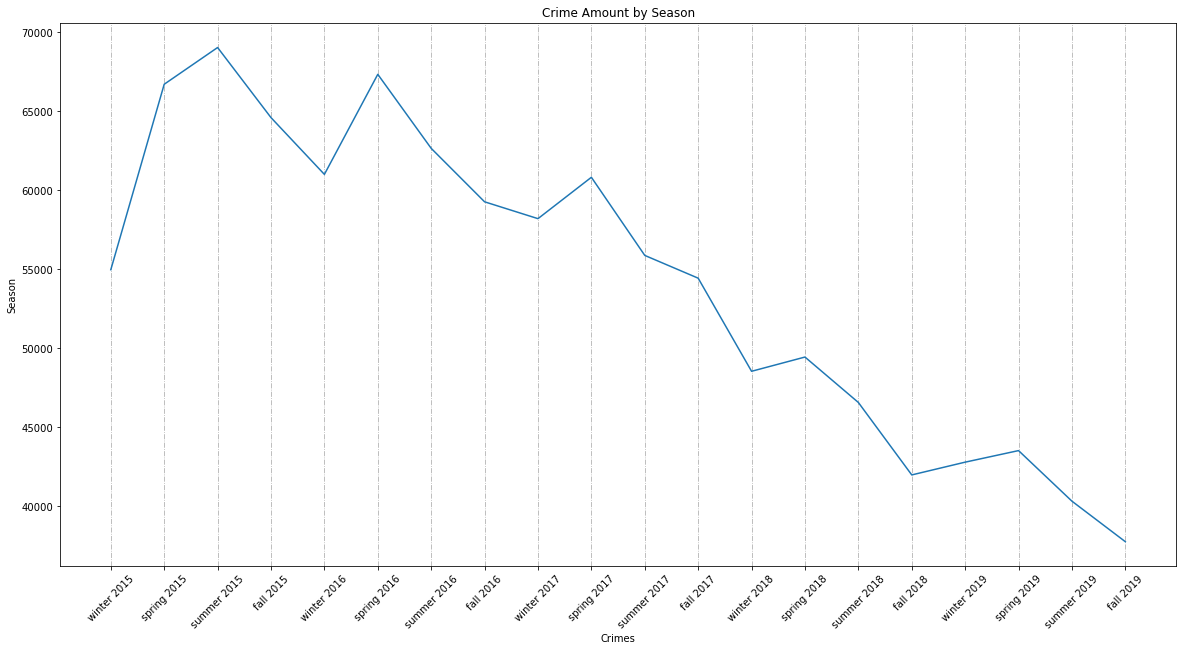

In [168]:
plt.figure(figsize=(20,10)) 
plt.plot(season,crimeAmt)
plt.title('Crime Amount by Season')
plt.xlabel('Crimes')
plt.ylabel('Season')
plt.grid(axis = 'x',linestyle='-.')
plt.xticks(rotation = 45) 
plt.show()

In [162]:
recent_df.sort_values('arrest_date',ascending=True)

,arrest_key,arrest_date,pd_desc,ofns_desc,law_code,law_cat_cd,age_group,perp_sex,perp_race,latitude,longitude,arrest_boro,arrest_precinct,jurisdiction_code,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih
1288579,139900400,2014-12-01,"FORGERY-ILLEGAL POSSESSION,VEHICLE IDENT. NU",MISCELLANEOUS PENAL LAW,PL 1707003,F,18-24,M,BLACK,40.848754,-73.865465,B,49,0.0,59.0,5.0,22.0,32.0
1291538,139900387,2014-12-01,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",PETIT LARCENY,PL 1552500,M,18-24,F,BLACK,40.868467,-73.821583,B,45,0.0,43.0,5.0,2.0,28.0
1281319,139900619,2014-12-01,OBSTR BREATH/CIRCUL,ASSAULT 3 & RELATED OFFENSES,PL 1211100,M,45-64,M,BLACK,40.710786,-73.789642,Q,103,0.0,41.0,3.0,6.0,61.0
1279858,139897836,2014-12-01,"MENACING,UNCLASSIFIED",ASSAULT 3 & RELATED OFFENSES,PL 1201401,M,<18,M,WHITE HISPANIC,40.811156,-73.909823,B,40,0.0,49.0,5.0,35.0,23.0
1307844,139900464,2014-12-01,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,PL 1200502,F,18-24,M,BLACK,40.701538,-73.923135,K,83,0.0,42.0,2.0,30.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151055,206888896,2019-12-31,"LARCENY,PETIT FROM OPEN AREAS,",PETIT LARCENY,PL 1552500,M,25-44,M,ASIAN / PACIFIC ISLANDER,40.837503,-73.887696,B,42,0.0,34.0,5.0,43.0,25.0
162271,206890918,2019-12-31,"PUBLIC SAFETY,UNCLASSIFIED MIS",OFFENSES AGAINST PUBLIC SAFETY,PL 2700502,M,25-44,M,WHITE HISPANIC,40.699591,-73.951780,K,79,2.0,36.0,2.0,38.0,56.0
161540,206882738,2019-12-31,"TRAFFIC,UNCLASSIFIED INFRACTIO",OTHER TRAFFIC INFRACTION,VTL051101A,M,25-44,M,WHITE,40.756812,-73.873657,Q,115,97.0,65.0,3.0,21.0,73.0
150974,206887259,2019-12-31,"ROBBERY,OPEN AREA UNCLASSIFIED",ROBBERY,PL 1600500,F,<18,M,BLACK,40.813775,-73.940054,M,32,0.0,18.0,4.0,36.0,20.0


In [172]:
from ipywebrtc import WidgetStream, ImageRecorder

def saveMap(m,frame):
    widget_stream = WidgetStream(widget=m, max_fps=1)
    image_recorder = ImageRecorder(stream=widget_stream)
    display(image_recorder)

    with open('map_' + str(frame)+'.png', 'wb') as f:
        f.write(image_recorder.image.value)

In [202]:
relCols = ["latitude","longitude","ofns_desc"]
mapdf = seasons[0][relCols]
#mapdf = mapdf[mapdf["ofns_desc"]=="F"]
#mapdf["law_cat_cd"].replace({"F": 1000}, inplace=True)

heatList = []
for index, row in mapdf.iterrows():
    heatList.append([row['latitude'], row['longitude'],1000])

grad = {0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
heatmap = Heatmap(locations=heatList,radius=3,blur=9)
m = Map(center=(40.785091, -73.968285), zoom=11, gradient=grad)
m.add_layer(heatmap)
m

Map(center=[40.785091, -73.968285], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [203]:
from ipyleaflet import WidgetControl,FullScreenControl

In [209]:
def getMonthlyData(month,endYear):
    df = recent_df[(pd.to_datetime(recent_df['arrest_date']).dt.month == month) & 
                   (pd.to_datetime(recent_df['arrest_date']).dt.year == endYear)]
    return df

In [221]:
months = []
x = 2015
for i in range(5):
    for i2 in range(12):
        months.append(getMonthlyData(i2+1,x+i))

In [223]:
# this will save html versions of each dataset
# further processing is needed to create images/screenshots

j = 0
for i in months:
    relCols = ["latitude","longitude","law_cat_cd"]
    mapdf = i[relCols]
    #mapdf = mapdf[mapdf["law_cat_cd"]=="F"]
    #mapdf["law_cat_cd"].replace({"F": 1000}, inplace=True)

    heatList = []
    for index, row in mapdf.iterrows():
        heatList.append([row['latitude'], row['longitude'],1000])

    grad = {0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
    heatmap = Heatmap(locations=heatList,radius=3,blur=9)
    m = Map(center=(40.785091, -73.968285), zoom=11, gradient=grad)
    m.add_layer(heatmap)
    m.add_control(FullScreenControl())
    m.save('my_map_'+str(j)+'.html', title='My Map')
    j=j+1